Sources:

- https://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
- https://de.wikipedia.org/wiki/Ellipsoid#Parameterdarstellung_2
- https://de.wikipedia.org/wiki/Hauptachsentransformation#Diagonalisierung_einer_symmetrischen_Matrix_(Hauptachsentheorem)
- https://stackoverflow.com/a/38426572/333403

In [1]:

# good for interactive exploration on local notebook server
# %matplotlib notebook

%matplotlib inline
%load_ext ipydex.displaytools

ZZ.shape := (3, 20, 20)

---


P := array([[ 1.85794162e+00,  1.12539585e-03, -3.16600086e-01],
            [ 1.12539585e-03,  1.42419847e+00, -2.07430875e-01],
            [-3.16600086e-01, -2.07430875e-01,  1.21785991e+00]])

---


(np.linalg.eigvals(P)) := array([2. , 1. , 1.5])

---


M := array([[0.70710678, 0.        , 0.        ],
            [0.        , 1.        , 0.        ],
            [0.        , 0.        , 0.81649658]])

---


(evects) := array([[-0.90258505, -0.31428736, -0.29421705],
                   [-0.14747164, -0.41635434,  0.89716285],
                   [ 0.40446549, -0.85315445, -0.32944673]])

---


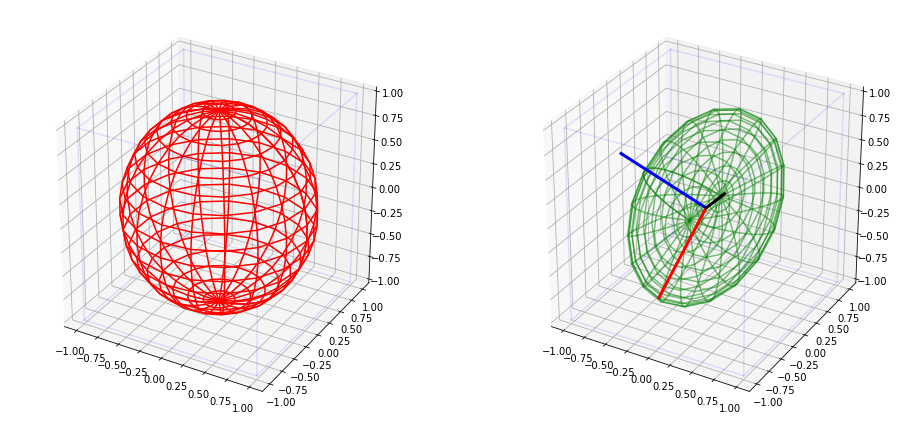

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(1, 2, 1, projection='3d', aspect='equal')
ax2 = fig.add_subplot(1, 2, 2, projection='3d', aspect='equal')

# draw cubes for reference

def draw_cube(l):
    r = [-l, l]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            ax1.plot3D(*zip(s, e), color="b", alpha=0.1)
            ax2.plot3D(*zip(s, e), color="b", alpha=0.1)

draw_cube(1)
# draw_cube(2)

# draw sphere

N = 20 # resolution
UU = np.linspace(0, 2*np.pi, N)
VV = np.linspace(0, np.pi, N)

u, v = np.meshgrid(UU, VV)


# u and v are parameters to address a point on the unit sphere (and later on the ellipsoid)
# transform from spherical coordinates to cartesian coords
zz1 = np.cos(u)*np.sin(v)
zz2 = np.sin(u)*np.sin(v)
zz3 = np.cos(v)

ax1.plot_wireframe(zz1, zz2, zz3, color="r")


# plot ellipsoid

# every array in (zz1, zz2, zz3) has shape (N, N).
# We need xx1, xx2, xx3 for which  xx = A@zz holds pointwise

ZZ = np.stack((zz1, zz2, zz3), axis=0) ##:S

# construct a suitable P
# random orthogonal matrix 
np.random.seed(1620)
from scipy.stats import ortho_group
R = ortho_group.rvs(dim=3)
P0 = np.diag([2, 1.5, 1])
P = R.T@P0@R ##:

# ensure symmetry (because of numerical noise)
P = (P + P.T)/2

np.linalg.eigvals(P) ##:

assert np.alltrue(P == P.T)

evals, evects = np.linalg.eig(P)

# Scale -Matrix
M = np.diag(np.sqrt(1/(evals))) ##:

# overall transformation matrix
T = np.dot(evects, M)

evects ##:

# XX = evects@ZZ ##:S
# xx1, xx2, xx3 = XX.transpose(1, 0, 2)

XX = np.einsum("ij,jkl->ikl", T, ZZ)


xx1, xx2, xx3 = XX

ax2.plot_wireframe(xx1, xx2, xx3, color="g", alpha=0.5)

ax2.plot(*zip([0, 0, 0], evects[:, 0]), "b-", lw=3)
ax2.plot(*zip([0, 0, 0], evects[:, 1]), "r-", lw=3)
ax2.plot(*zip([0, 0, 0], evects[:, 2]), "k-", lw=3)


plt.show()


Remark w.r.t `XX = np.einsum("ij,jkl->ikl", T, ZZ)`: This can be easily understood if the matrix-vector multiplication is written down as sum formula:

$$
\sum_j T_{ij} z_j = x_i
$$

However we have `ZZ.shape= (3, N, N)`, i.e. $z$ has three indices and accordingly $x$ must have three as well:

$$
\sum_j T_{ij} z_{jkl} = x_{ikl}.
$$

Over the additional indices ($kl$) no summation takes place and there is no multiplication which involves theses indices as they do not occure twice on the left hand side of the comma (Einstein summation convention).


https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html?highlight=einsum#numpy.einsum

https://stackoverflow.com/questions/26089893/understanding-numpys-einsum